In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

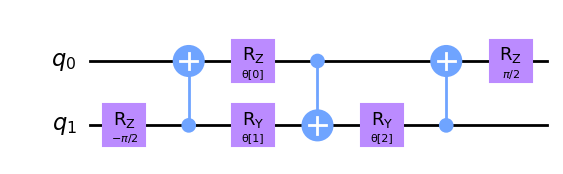

In [2]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

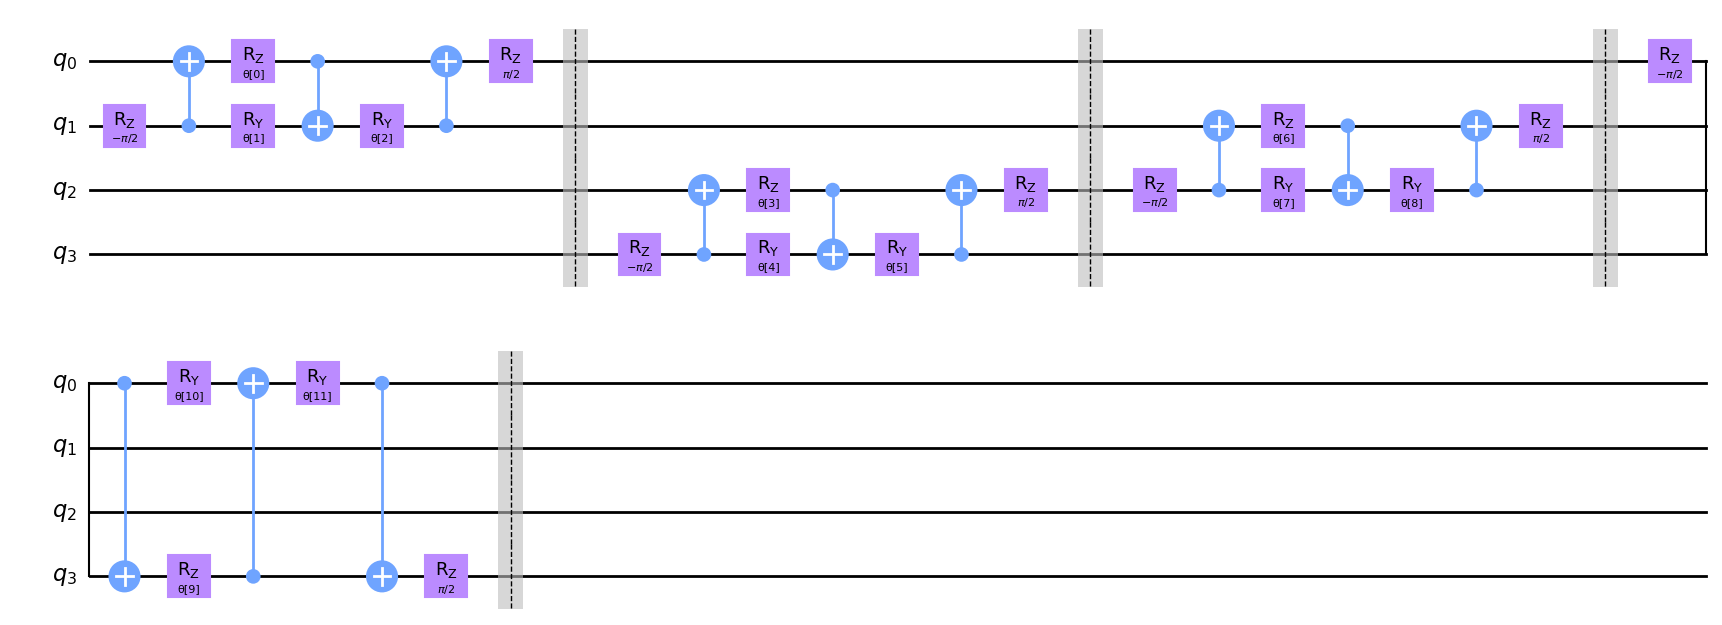

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

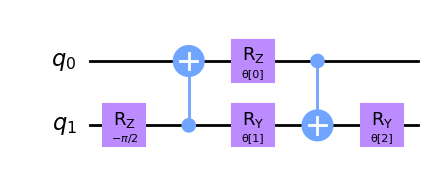

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

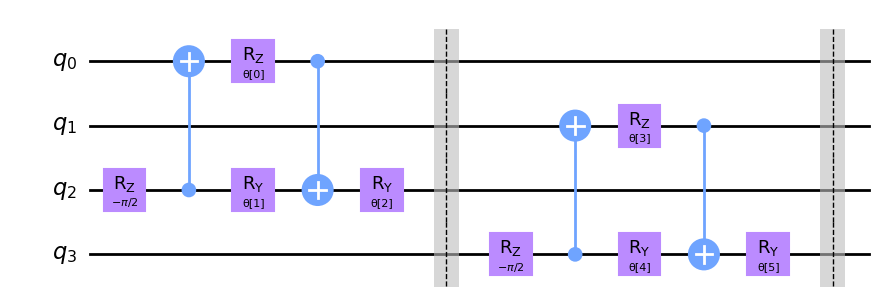

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [6]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [7]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

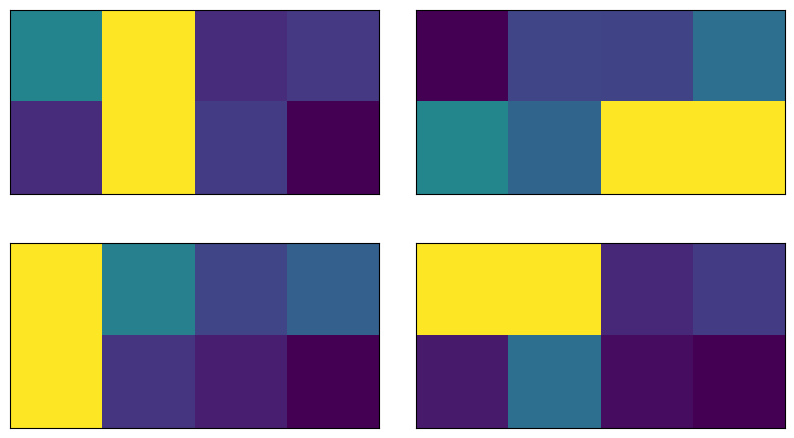

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

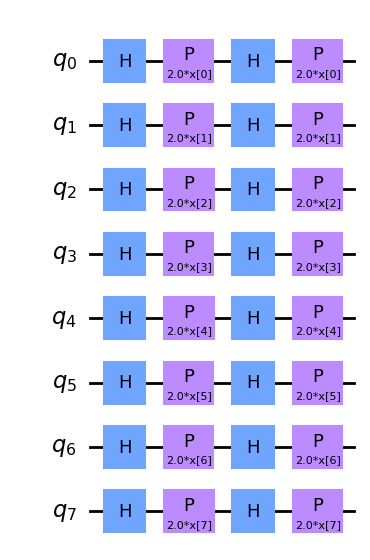

In [9]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [10]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

#observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
observable = SparsePauliOp.from_list([("I"*7 + "Z", 1)])  # measure qubit 7


# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [11]:
latest_weights = None  # global to keep the newest point

def callback_graph(weights, obj_func_eval):
    global latest_weights
    latest_weights = np.array(weights, dtype=float)  # keep the most recent
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [12]:
import json, numpy as np

def _extract_trained_weights(classifier, latest_weights=None):
    # 1) Prefer the last point seen in the callback
    if latest_weights is not None:
        return np.asarray(latest_weights, dtype=float)

    # 2) Try optimizer result attached to the classifier
    for attr in ("fit_result", "_fit_result"):
        res = getattr(classifier, attr, None)
        if res is not None:
            # qiskit/algorithms OptimizerResult usually has .x
            for name in ("x", "optimal_point", "point"):
                if hasattr(res, name):
                    return np.asarray(getattr(res, name), dtype=float)
            if isinstance(res, dict):
                for key in ("x", "optimal_point", "point"):
                    if key in res:
                        return np.asarray(res[key], dtype=float)

    # 3) Try other common fields
    for attr in ("weights", "_weights"):
        if hasattr(classifier, attr):
            return np.asarray(getattr(classifier, attr), dtype=float)

    # 4) Try the underlying network
    nn = getattr(classifier, "neural_network", None)
    if nn is not None:
        for attr in ("weights", "_weights"):
            if hasattr(nn, attr):
                return np.asarray(getattr(nn, attr), dtype=float)

    raise AttributeError("Could not locate learned weights on classifier.")

def save_qcnn_checkpoint(path, classifier, train_images, train_labels, test_images, test_labels, objective_vals, extra=None):
    weights = _extract_trained_weights(classifier, latest_weights)
    ckpt = {
        "weights": weights.tolist(),
        "train_images": [np.asarray(x).tolist() for x in train_images],
        "train_labels": list(np.asarray(train_labels).astype(int)),
        "test_images":  [np.asarray(x).tolist() for x in test_images],
        "test_labels":  list(np.asarray(test_labels).astype(int)),
        "objective_vals": list(map(float, objective_vals)),
        "random_seed": getattr(algorithm_globals, "random_seed", None),
        "qnn_num_weights": int(getattr(classifier.neural_network, "num_weights", 0)),
        "notes": extra or "",
    }
    with open(path, "w") as f:
        json.dump(ckpt, f, default=_json_default, ensure_ascii=False)
    print(f"✅ Saved checkpoint to {path}")

def load_qcnn_checkpoint(path):
    with open(path, "r") as f:
        ckpt = json.load(f)
    initial_point = np.array(ckpt["weights"], dtype=float)
    train_images = np.array(ckpt["train_images"], dtype=float)
    train_labels = np.array(ckpt["train_labels"], dtype=int)
    test_images  = np.array(ckpt["test_images"], dtype=float)
    test_labels  = np.array(ckpt["test_labels"], dtype=int)
    objective_vals = list(map(float, ckpt.get("objective_vals", [])))
    print(f"✅ Loaded checkpoint from {path} (weights: {initial_point.shape[0]} params)")
    return initial_point, train_images, train_labels, test_images, test_labels, objective_vals


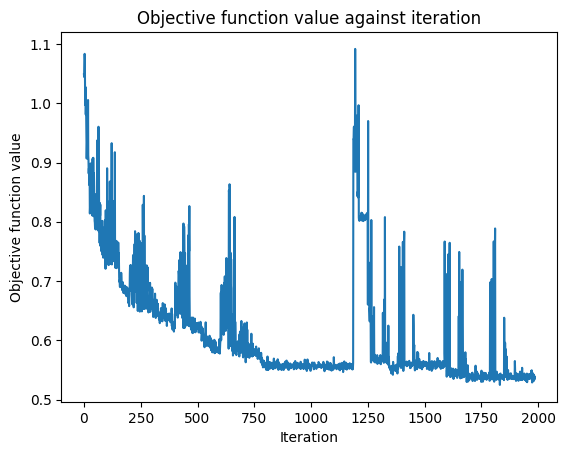

NameError: name 'x' is not defined

In [13]:
#with open("11_qcnn_initial_point.json", "r") as f:
#    initial_point = json.load(f)

"""classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)"""

# rebuild the same QNN...
initial_point, train_images, train_labels, test_images, test_labels, objective_vals_prev = load_qcnn_checkpoint("qcnn_checkpoint.json")
objective_func_vals = list(objective_vals_prev)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point
)
classifier.fit(np.asarray(train_images), np.asarray(train_labels))

print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")


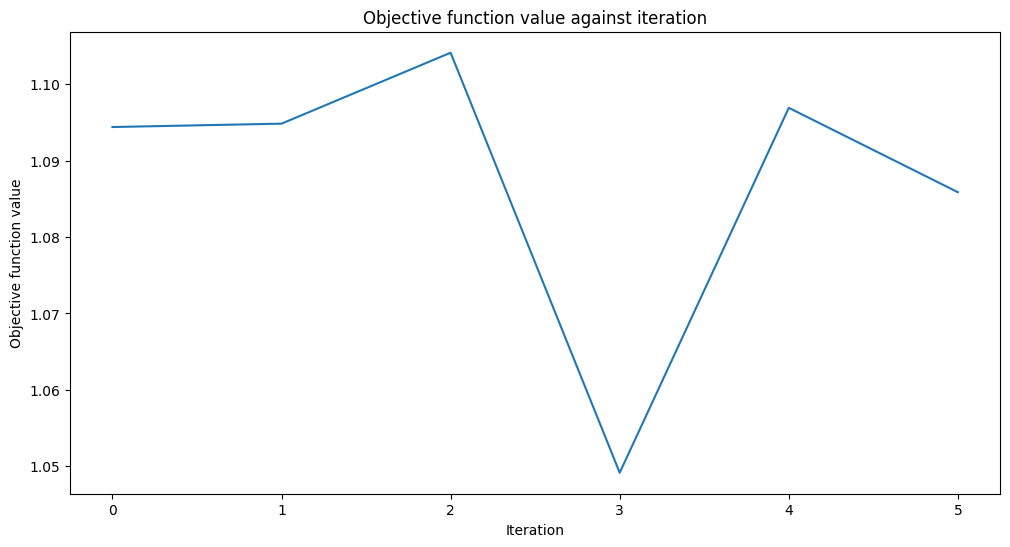

KeyboardInterrupt: 

In [36]:
"""x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")"""

In [65]:
import json
import numpy as np

def _json_default(o):
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    # last resort: string
    return str(o)


In [66]:
# After training completes
save_qcnn_checkpoint(
    "qcnn_checkpoint.json",
    classifier,
    train_images, train_labels,
    test_images,  test_labels,
    objective_func_vals,
    extra="QCNN conv/pool layout; COBYLA(maxiter=200)"
)


✅ Saved checkpoint to qcnn_checkpoint.json


Accuracy from the test data : 80.0%


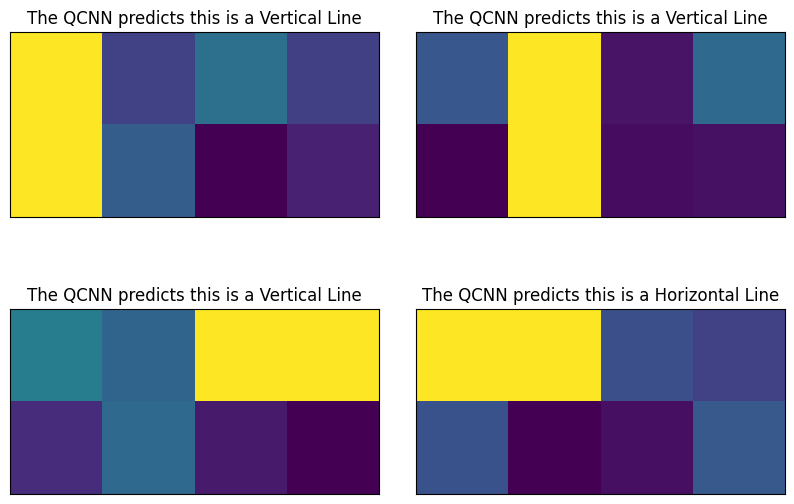

In [67]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)